### **Lightweight Fine-Tuning Project**

TODO: In this cell, describe your choices for each of the following

- PEFT technique: **LoRA**

- Model: **ResNet18**

- Evaluation approach: **Transformer**

- Fine-tuning dataset: **Pokémon dataset**

### **Import Libraries**

In [1]:
import os
import torch
import requests
import datasets as np
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from datasets import load_dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

from io import BytesIO
from PIL import Image

/Users/tsaijou/udacity-generative-ai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Load Dataset**

In [2]:
# load the pokemon-classification dataset
dataset_pokekon = load_dataset("keremberke/pokemon-classification", 'full')

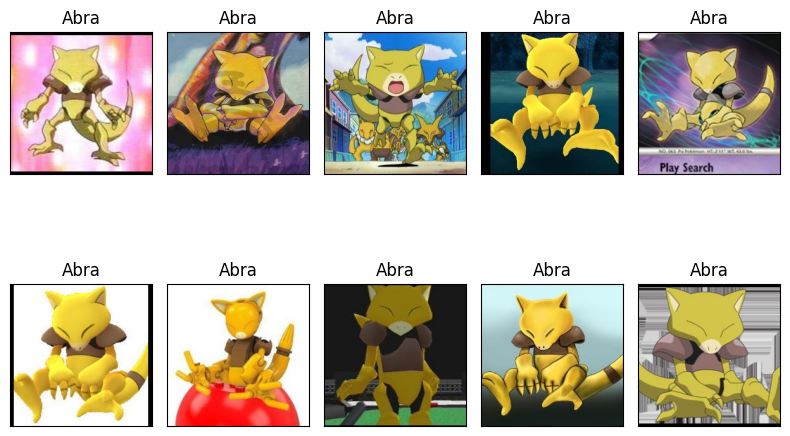

In [75]:
def image_to_tensor(image):
    # Create a transform to convert PIL Image to tensor
    transform = transforms.ToTensor()
    # Apply the transform
    tensor = transform(image)
    return tensor

fig = plt.figure(figsize=(8, 6))
plot_size = 10

for idx in range(plot_size):
    # Access the image and label correctly
    image = dataset_pokekon['train']['image'][idx]
    label_idx = dataset_pokekon['train']['labels'][idx]

    label = label_name = dataset_pokekon['train'].features['labels'].names[label_idx]
    # Convert PIL image to tensor
    image_tensor = image_to_tensor(image)

    # show the image
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(image_tensor.permute(1, 2, 0))  # matplotlib expects channels last
    ax.set_title(label)

plt.tight_layout()
plt.show()


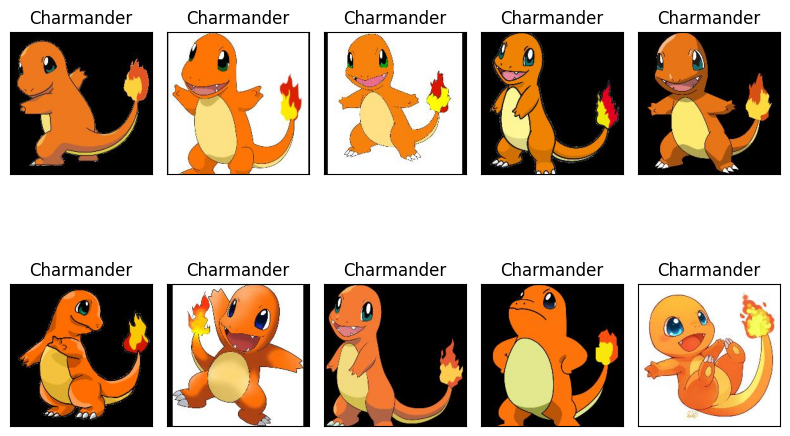

In [9]:
fig = plt.figure(figsize=(8, 6))
plot_size = 10
target_label = 'Charmander'  # 假設目標標籤是 'Charmander'

# 確保找到指定標籤的圖片
found_images = 0
for idx, label in enumerate(dataset_pokekon['train']['labels']):
    # 使用標籤字典將數字標籤轉換為名稱
    label_name = dataset_pokekon['train'].features['labels'].names[label]
    
    # 檢查標籤是否包含目標標籤字串
    if target_label.lower() in label_name.lower():  # 使用小寫進行比較，以確保大小寫不敏感
        found_images += 1
        if found_images > plot_size:
            break  # 限制找到的圖片數量不超過 plot_size
        image = dataset_pokekon['train']['image'][idx]

        # 顯示圖片
        ax = fig.add_subplot(2, plot_size // 2, found_images, xticks=[], yticks=[])
        ax.imshow(image)
        ax.set_title(label_name)

# 如果沒有找到指定標籤的圖片，顯示相應消息
if found_images == 0:
    print("No images found containing the specified label:", target_label)

plt.tight_layout()
plt.show()


> anothor Pokémon datasets

In [65]:
# load the PokemonCard sdataset
dataset = load_dataset("TheFusion21/PokemonCards")

# dataset -> training set and test set
train_dataset, test_dataset= train_test_split(dataset['train'],test_size=0.2, random_state=42)

train_images = train_dataset['image_url']
test_images = test_dataset['image_url']
train_labels = train_dataset['name']
test_labels = test_dataset['name']

num_classes = set(train_labels)
print(len(train_labels))
print(len(num_classes))

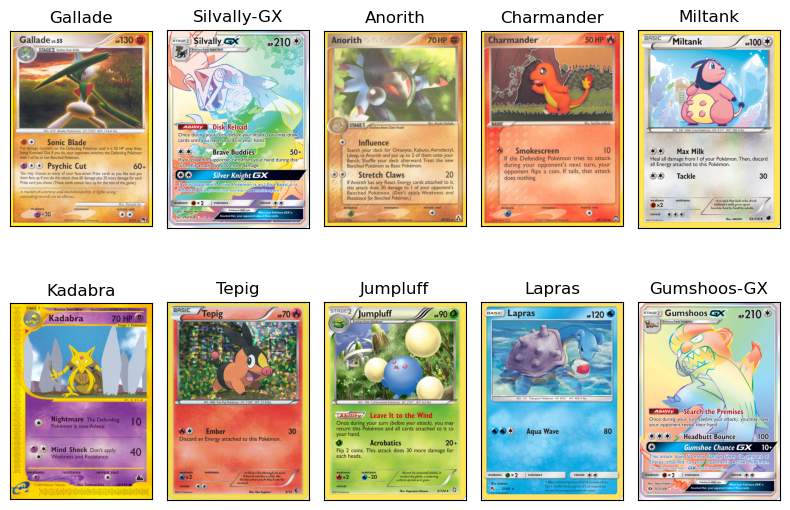

In [22]:
# show the first 10 images with their labels

fig = plt.figure(figsize=(8, 6))
plot_size = 10

for idx in range(plot_size):
    # read the image URL and label
    image_url = train_images[idx]
    label = train_labels[idx]

    # download and read the image
    response = requests.get(image_url)
    image = np.array(Image.open(BytesIO(response.content)))

    # show the image
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(image)
    ax.set_title(label)

plt.tight_layout()
plt.show()


### **Loading and Evaluating a Foundation Model**

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, subset='train', transform=None):
        self.data = data
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.data[self.subset])

    def __getitem__(self, idx):
        image = self.data[self.subset][idx]['image']
        label = self.data[self.subset][idx]['labels']

        image = self.transform(image)
        label_tensor = torch.tensor(label)

        return {'image': image, 'label': label_tensor}

In [4]:
# Create the transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to (224, 224)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

train_dataset = CustomDataset(data=dataset_pokekon, subset='train', transform=transform)
validation_dataset = CustomDataset(dataset_pokekon, subset='validation', transform=transform)
test_dataset = CustomDataset(dataset_pokekon, subset='test', transform=transform)

# Create the dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(
        train_dataset if x == 'train' else validation_dataset,
        batch_size=10,
        shuffle=True ,
        num_workers=0
    ) for x in ['train', 'validation', 'test']
}

dataset_sizes = {x: len(dataset_pokekon[x]) for x in ['train', 'validation', 'test']}
print("Dataset sizes:", dataset_sizes)

Dataset sizes: {'train': 4869, 'validation': 1390, 'test': 732}


In [5]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the device to be used for the tensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/Users/tsaijou/udacity-generative-ai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tsaijou/udacity-generative-ai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        elif phase == 'validation':
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        
        for batch in dataloaders[phase]:            
            # Move images and labels tensor to device
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {epoch_acc:.4f}')
    print('')

> It can be observed that this model is overfitting.

### **Performing Parameter-Efficient Fine-Tuning**

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

In [6]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the new linear layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 276)

# Define the LoRA configuration
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["fc"],
    lora_dropout=0.1,
    bias="none",
)

# Wrap the base model with LoRA using get_peft_model
lora_model = get_peft_model(model, config)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lora_model.parameters(), lr=0.001)

# Set the device to be used for the tensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lora_model = lora_model.to(device)

In [ ]:
# LoRA Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            lora_model.train()
        elif phase == 'validation':
            lora_model.eval()

        running_loss = 0.0
        running_corrects = 0

        for batch in dataloaders[phase]:
            # Move images and labels tensor to device
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = lora_model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {epoch_acc:.4f}')
    print('')

In [70]:
torch.save(lora_model.state_dict(), 'peft_model.pth')

### **Performing Inference with a PEFT Model**

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [8]:
# Evaluate the original model
model.eval()
all_predictions_peft = []
true_labels_peft = []
with torch.no_grad():
    for batch in dataloaders['test']:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions_peft.extend(predicted.cpu().numpy())
        true_labels_peft.extend(labels.cpu().numpy())

baseline_accuracy = accuracy_score(true_labels_peft, all_predictions_peft)

# Evaluate the new model
lora_model.eval()
all_predictions_baseline = []
true_labels_baseline = []
with torch.no_grad():
    for batch in dataloaders['test']:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        outputs = lora_model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions_baseline.extend(predicted.cpu().numpy())
        true_labels_baseline.extend(labels.cpu().numpy())

peft_accuracy = accuracy_score(true_labels_baseline, all_predictions_baseline)

# Displaying the results
data = {'Model': ['Baseline', 'PEFT'],
        'Accuracy': [baseline_accuracy, peft_accuracy]}
df = pd.DataFrame(data)
df


,Model,Accuracy
0,Baseline,0.000719
1,PEFT,0.000719
